In [1]:
# Colab setup: install deps and clone repo if needed
!pip -q install geopandas rasterio shapely pyproj xarray h5netcdf scikit-learn seaborn

import os
from pathlib import Path

repo_dir = Path('SGS_training')
if not repo_dir.exists():
    !git clone https://github.com/MinersAI/SGS_training.git
%cd SGS_training

os.environ.setdefault('SGS_PROJECT_ROOT', os.getcwd())
os.environ.setdefault('SGS_DATA_ROOT', str(Path(os.getcwd()) / 'data'))


Cloning into 'SGS_training'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (48/48), done.
^Cceiving objects:  83% (189/226), 85.29 MiB | 5.72 MiB/s
[Errno 2] No such file or directory: 'SGS_training'
/Users/thowe/Documents/Work/SGS_training


'/Users/thowe/Documents/Work/SGS_training/data'

# SGS Analytical Methods

Now that we understand our data formats and have preprocessed our datasets, we can apply analytical methods to extract geological insights.

**What we'll cover:**
- **Interpolation** — converting point samples to continuous surfaces (IDW, Kriging)
- **PCA** — reducing dimensionality and finding dominant geochemical signatures
- **Clustering** — identifying geochemical populations
- **Anomaly detection** — flagging unusual multivariate signatures
- **Spectral classification** — mapping alteration halos from satellite imagery
- **Supervised ML** — predicting prospectivity from integrated datasets

Each method has strengths and limitations—the goal is to understand when and why to use them.

## Imports


In [1]:
import helpers as h

## Load Helpers and Prepare Data


In [7]:
# Load training data

data = h.load_training_data()

continuous_raster = data['continuous_raster']
raster_extent = data['raster_extent']
raster_crs = data['raster_crs']
vector_gdf = data['vector_gdf']
categorical_raster = data['categorical_raster']
geochem_gdf = data['geochem_gdf']

feature_cols, value_col = h.prepare_geochem_features(geochem_gdf)
print('\nData loaded and ready for preprocessing.')



Total Files: 16 
 - Vector Files: 3 
 - Raster Files: 13

Raster shape: (351, 396)
Vector records: 463
Geochem records: 1243

Data loaded and ready for preprocessing.


-----------

## Analytical Methods

The following sections demonstrate common analytical techniques used in mineral exploration. We'll work through each method, show results, and discuss interpretation.

### Interpolation (IDW + Kriging)

**The problem:** We have point samples (1,243 geochem locations), but we want a continuous surface showing predicted values across the entire area.

**Inverse Distance Weighting (IDW):** Simple and intuitive—predicts values at unknown locations as a weighted average of nearby samples, with closer samples weighted more heavily.

**Kriging:** A geostatistical method that also uses distance-based weighting, but additionally accounts for the spatial structure of the data (via a variogram). It provides uncertainty estimates along with predictions.

We'll interpolate our Cu values onto a 49 × 60 grid covering the study area.

In [4]:
# First, generate the grid

print('Running interpolation setup...')
interp_inputs = h.prepare_interpolation_inputs(geochem_gdf, value_col)
sample_coords, sample_values, grid_points, grid_shape, interp_extent = interp_inputs
print(f'Interpolation grid ready: {grid_shape[0]} x {grid_shape[1]}')


Running interpolation setup...
Interpolation grid ready: 49 x 60


Running IDW interpolation...


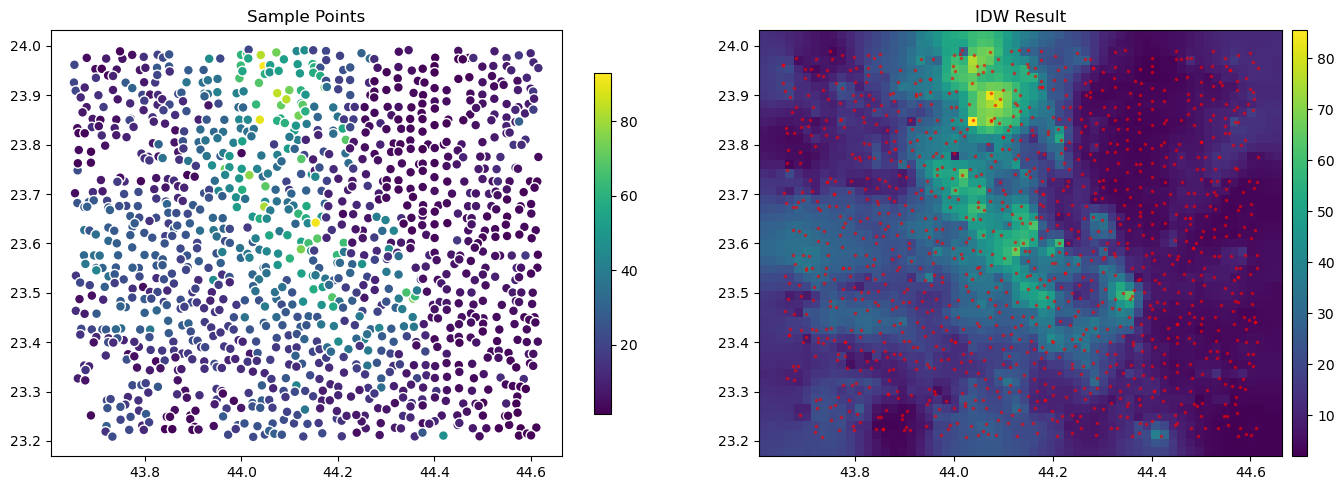

In [5]:
# Second, run the IDW interpolation

print('Running IDW interpolation...')
idw_grid = h.run_idw_interpolation(
    sample_coords, sample_values, grid_points, grid_shape, interp_extent
)


**IDW Result Interpretation:**

The left panel shows our original sample points colored by Cu value. The right panel shows the IDW interpolation:

- Red dots mark sample locations overlaid on the interpolated grid
- The interpolated surface clearly shows the Cu anomaly in the upper-center region (70-90 ppm, yellow)
- Notice how IDW creates "bullseye" patterns around high-value samples—this is a known characteristic of the method
- The interpolation preserves exact sample values at sample locations

IDW is fast and easy to understand, making it a good first-pass visualization. However, it can create artificial patterns and doesn't provide uncertainty estimates.

Running ordinary kriging interpolation...


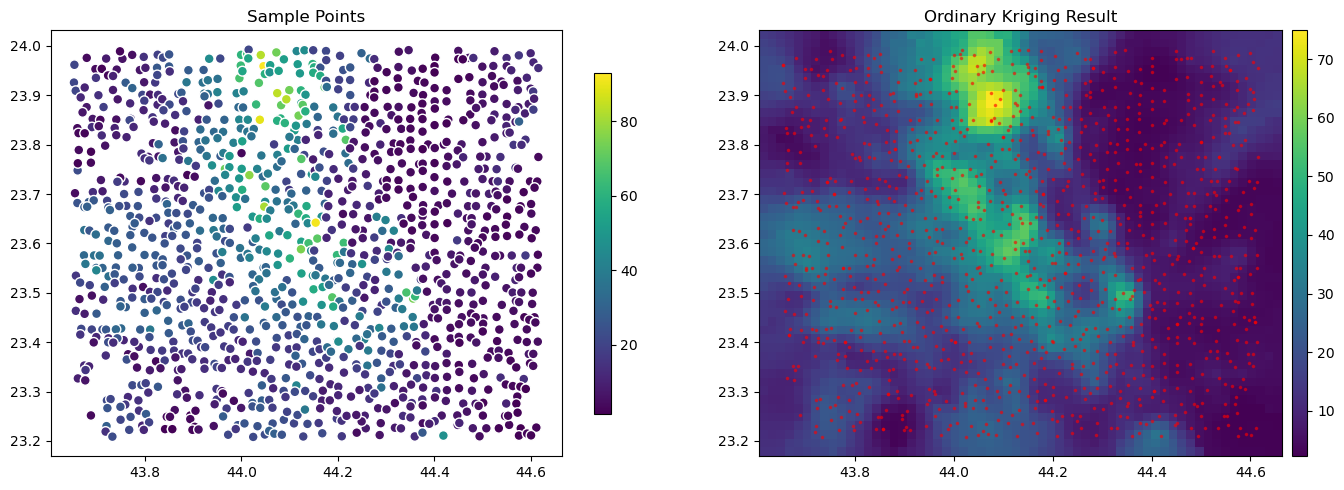

In [6]:
# Third, run the ordinary kriging interpolation

print('Running ordinary kriging interpolation...')
kriging_grid, kriging_var = h.run_kriging_interpolation(
    sample_coords, sample_values, grid_points, grid_shape, interp_extent
)


**Kriging Result Interpretation:**

Compare the kriging result to IDW:

- The same Cu anomaly is visible in the upper-center, but the surface is **smoother**
- Kriging reduces the bullseye effect because it models the underlying spatial correlation structure
- The predicted range (10-70 ppm) is slightly compressed compared to IDW—kriging tends toward the mean in areas of uncertainty

**Key advantages of kriging:**
1. Provides variance estimates (not shown here) so you know where predictions are uncertain
2. Optimal in a statistical sense (minimizes prediction error)
3. Better handles clustered sampling

**When to use which:** IDW for quick visualization; kriging when you need defensible predictions or uncertainty quantification.

-----------

### PCA (Principal Component Analysis)

**The problem:** Our geochem dataset has 57 variables. Many are correlated, and it's impossible to visualize or interpret 57-dimensional data directly.

**What PCA does:** Transforms the original variables into new, uncorrelated "principal components" (PCs) that capture the main patterns of variation. PC1 captures the most variance, PC2 the second most, and so on.

**Why it's useful for exploration:**
- Reduces noise by focusing on major patterns
- Often reveals geologically meaningful element associations
- Can highlight samples with unusual multi-element signatures

In [8]:
# --- USER PARAMETERS: PCA Preprocessing ---
# transform: How to handle skewed geochemical distributions before PCA.
#   'none'  = use raw values (not recommended for most geochem data)
#   'log1p' = log(1+x) transform, normalizes right-skewed distributions

transform = 'log1p'           # Options: 'none', 'log1p'


# clip_quantiles: Remove extreme outliers before PCA. Format: (lower, upper).
#   None         = no clipping
#   (0.0, 0.95)  = clip top 5% of values (removes extreme highs)
#   (0.01, 0.99) = clip both tails (removes extreme highs and lows)

clip_quantiles = (0.0, 0.95)  # Try: None, (0.01, 0.99), (0.05, 0.95)


# scale_features: Whether to standardize features to mean=0, std=1.
#   True  = recommended, ensures all variables contribute equally regardless of units
#   False = variables with larger ranges will dominate PCA

scale_features = True         # Options: True, False

In [10]:
# Prepare and fit PCA model

print('Preparing PCA inputs...')

pca_inputs = h.prepare_pca_inputs(
    geochem_gdf,
    feature_cols,
    transform=transform,
    scale_features=scale_features,
    clip_quantiles_range=clip_quantiles,
)
X_scaled = pca_inputs['X_scaled']
pca_cols = pca_inputs['pca_cols']

print(f'PCA inputs ready: {len(pca_cols)} features')

print('Fitting PCA model...')
pca, X_pca = h.fit_pca_model(X_scaled)
print(f'PCA fitted: {X_pca.shape[1]} components')

Preparing PCA inputs...
Original dimensions: 57
PCA inputs ready: 57 features
Fitting PCA model...
PCA fitted: 57 components


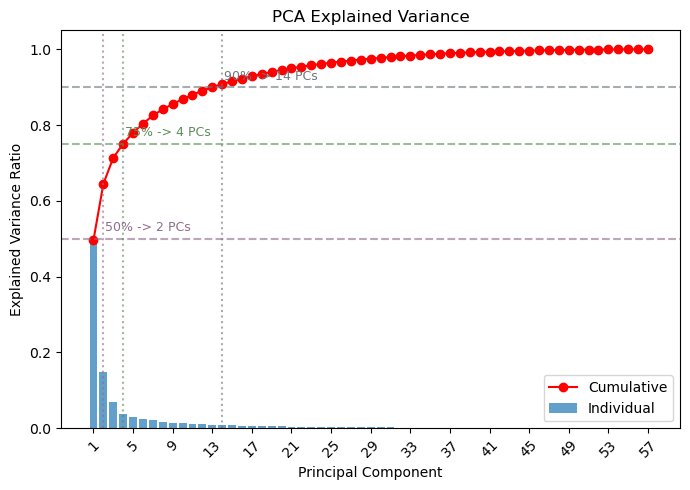

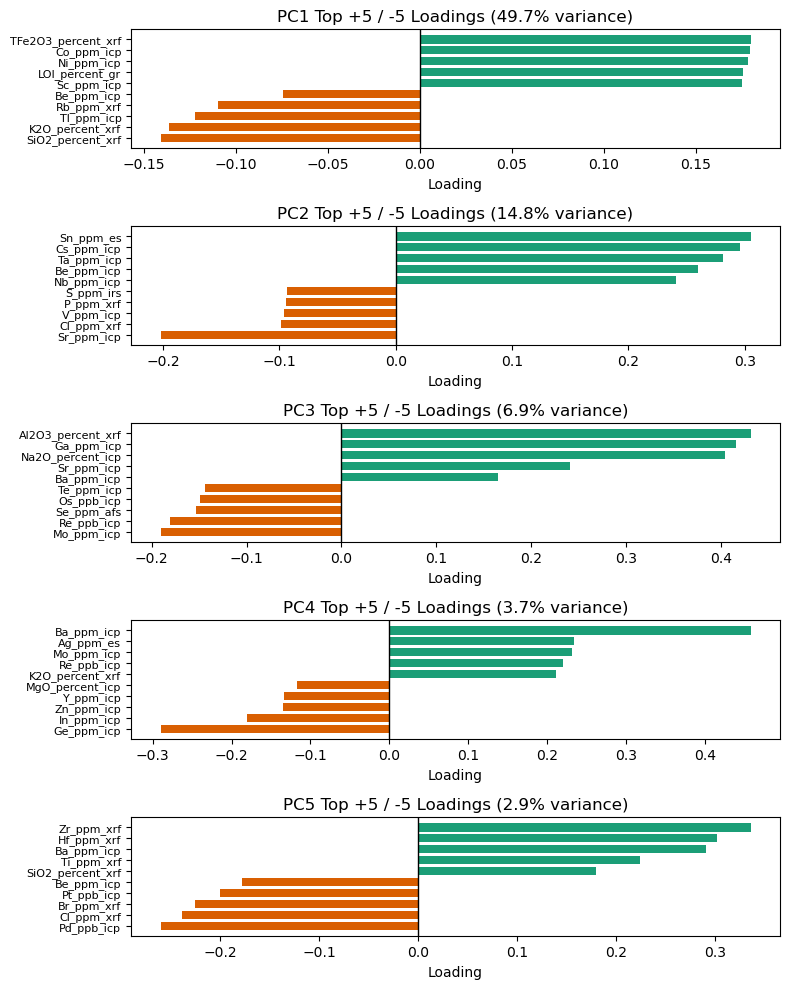

In [11]:
# Plot PCA results

_ = h.plot_pca_variance(pca)
_ = h.plot_pca_loadings(pca, pca_cols, n_components=5, top_n_pos=5, top_n_neg=5)
h.show_plot()


**PCA Variance Explained:**

The top plot shows how much variance each component captures:
- **PC1 alone captures 49.7%** of total variance—this is the dominant pattern in the data
- The first 2 PCs capture ~65%, first 5 capture ~78%
- This means we can represent most of the information with far fewer dimensions

------

**PCA Loadings Interpretation:**

**PC1 (49.7% variance):** Strong positive loadings for TFe2O3, Co, Ni, LOI, and Sc; strong negative loadings for SiO2, K2O, Tl, Rb, Be. This represents a fundamental lithological contrast—mafic compositions (Fe-rich, Co-Ni bearing) versus felsic compositions (Si-K rich).

**PC2 (14.8% variance):** Positive loadings for Sn, Cs, Ta, Be, and Nb (incompatible/granophile elements); negative loadings for Sr, Cl, V, P, and S. This likely captures a fractionation trend or a distinct evolved/pegmatitic signature.

**PC3 (6.9% variance):** Positive loadings for Al2O3, Ga, Na2O, Sr, and Ba (feldspathic elements); negative loadings for Mo, Re, Se, Os, and Te (chalcophile/precious metal suite). This may distinguish felsic alteration zones from sulfide-associated mineralization.

**PC4 (3.7% variance):** Positive loadings for Ba, Ag, Mo, Re, and K2O; negative loadings for Ge, In, Zn, Y, and MgO. This could represent a hydrothermal signature with Ba-Ag-Mo enrichment.

**PC5 (2.9% variance):** Positive loadings for Zr, Hf, Ba, Ti, and SiO2 (refractory/heavy mineral suite); negative loadings for Pd, Cl, Br, Pt, and Be. This may capture heavy mineral concentration or a specific igneous differentiation trend.

------

**Summary Table:**

| PC | Variance | Positive Loadings | Negative Loadings | Likely Interpretation (high ↔ low PC value) |
|----|----------|-------------------|-------------------|-----------------------------------|
| PC1 | 49.7% | TFe2O3, Co, Ni, LOI, Sc | SiO2, K2O, Tl, Rb, Be | Mafic ↔ Felsic |
| PC2 | 14.8% | Sn, Cs, Ta, Be, Nb | Sr, Cl, V, P, S | Evolved/pegmatitic ↔ Primitive |
| PC3 | 6.9% | Al2O3, Ga, Na2O, Sr, Ba | Mo, Re, Se, Os, Te | Feldspathic ↔ Chalcophile/sulfide |
| PC4 | 3.7% | Ba, Ag, Mo, Re, K2O | Ge, In, Zn, Y, MgO | Hydrothermal ↔ Background |
| PC5 | 2.9% | Zr, Hf, Ba, Ti, SiO2 | Pd, Cl, Br, Pt, Be | Heavy mineral/refractory ↔ Volatile/PGE |

In [12]:
# Plot spatial PCA components

_ = h.interactive_spatial_pca_components(geochem_gdf, X_pca, pca, n_components=5)


**Spatial Distribution of PC Scores:**

Mapping PC scores reveals their geological meaning:

**PC1 (45.9% variance):** Shows a strong E-W gradient. High values (red) in the west, low values (blue) in the east. This likely reflects a major lithological boundary or contact zone running through the study area.

**PC2 (15.6% variance):** A different spatial pattern with extreme values in the SE corner. This might capture a distinct geochemical domain or a localized process.

**PC3 (7.2% variance):** More scattered pattern with high values in the west. Given its loadings on In, Te, and Nb, areas with high PC3 scores could represent zones of interest for certain mineralization styles.

**Key takeaway:** PCA transforms abstract multi-element chemistry into mappable patterns that often correlate with geology.

-----------

### K-means Clustering (Geochemical Populations)

**The goal:** Automatically group samples into distinct geochemical populations based on their multi-element signatures.

**How K-means works:**
1. You specify the number of clusters (`k`)
2. The algorithm iteratively assigns samples to the nearest cluster center
3. Cluster centers are updated until assignments stabilize

**Choosing k:** We use two complementary methods:
- **Elbow method:** Looks for where adding more clusters stops significantly reducing within-cluster variance
- **Silhouette score:** Measures how well-separated clusters are (higher = better)

By default, we'll use the elbow method to suggest `k`, but you can override this based on geological interpretability.

In [14]:
# --- USER PARAMETERS: K-means Clustering ---
# USER_K_OVERRIDE: Manually set the number of clusters, or let the algorithm decide.
#   None = use the elbow method to automatically select k
#   2-8  = override with your own value based on geological reasoning
#
# Why override? You might have prior knowledge suggesting a specific number of
# geochemical populations (e.g., 3 lithologies = try k=3). Experiment to see
# which k produces the most geologically interpretable clusters.

USER_K_OVERRIDE = None  # Try: 3, 4, 5, or None for automatic selection

Running K-means clustering diagnostics...
Elbow method suggests k=4


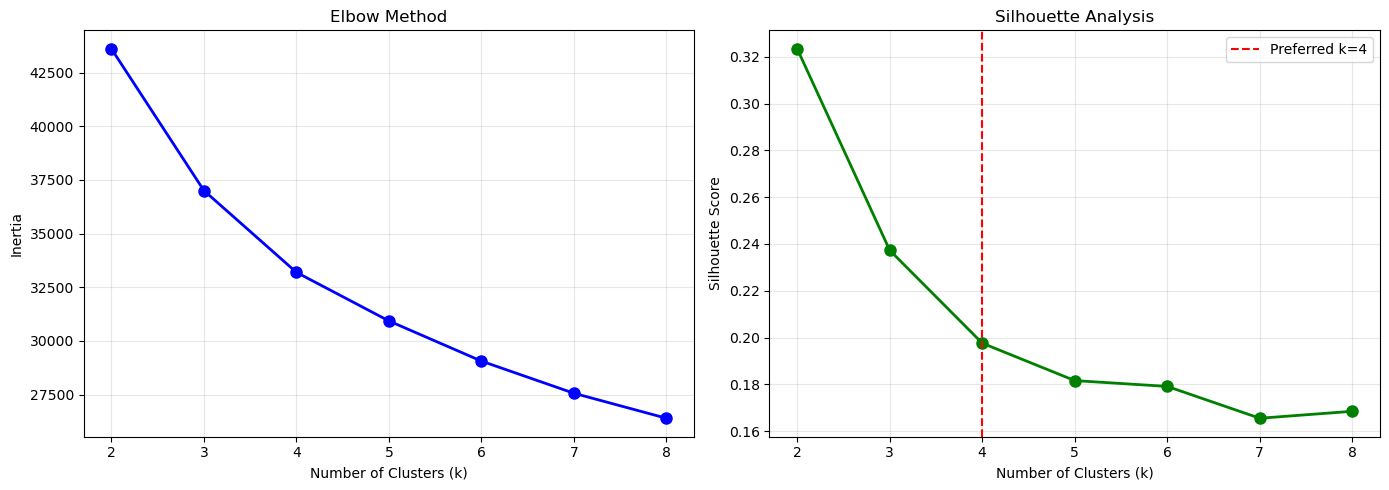

Clusters assigned: 4


In [15]:
print('Running K-means clustering diagnostics...')
k_range = list(range(2, 9))
inertias, silhouettes = h.run_kmeans_diagnostics(X_scaled, k_range)

chosen_k = h.choose_k(k_range, inertias, user_override=USER_K_OVERRIDE)

_ = h.plot_elbow_silhouette(k_range, inertias, silhouettes, preferred_k=chosen_k)
h.show_plot()

cluster_labels = h.run_kmeans_clustering(X_scaled, n_clusters=chosen_k)
print(f'Clusters assigned: {len(set(cluster_labels))}')

**Interpreting the Elbow and Silhouette Plots:**

**Elbow Method (left):** Shows within-cluster variance (inertia) vs. number of clusters.
- Inertia always decreases as `k` increases
- The "elbow" is where the rate of decrease slows—adding more clusters provides diminishing returns
- The algorithm identifies this automatically, but visual inspection is valuable

**Silhouette Score (right):** Measures cluster separation (-1 to 1 scale).
- High (near 1): Clusters are dense and well-separated
- Low (near 0): Clusters overlap significantly
- Negative: Samples might be assigned to wrong clusters

**In this example:**
- The silhouette score peaks at `k=2`, suggesting two main populations
- However, the elbow method and geological reasoning might support more clusters; in this case, the elbow method suggests `k=4`. We will use this to capture slightly more variation in the geochemical signature!
- We can also set a manual `k` override if we wish to test a hypothesis of a distinct number of geochemical species - this could be based off field observations, local system knowledge, or any other hypotheses you may wish to investigate

**The takeaway:** These metrics guide the decision, but geological interpretability often matters more than optimizing a single score.

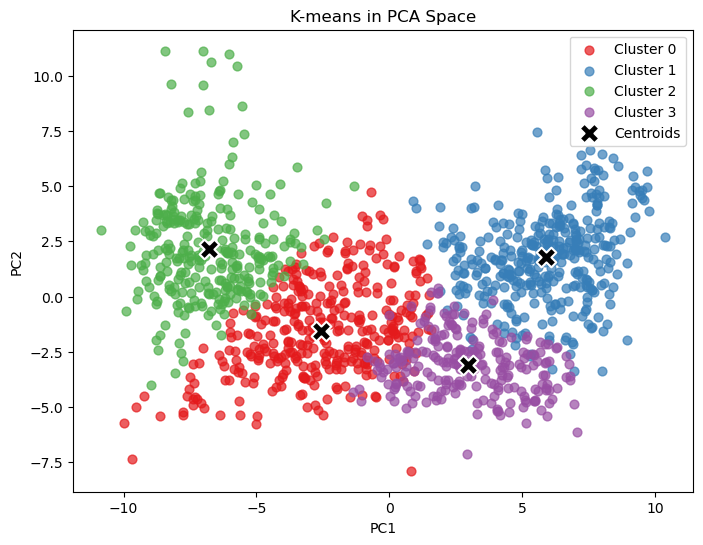

In [16]:
# Plot K-means in PCA space

_ = h.plot_kmeans_pca_scatter(X_pca, cluster_labels)
h.show_plot()


**K-means in PCA Space:**

This scatter plot shows our 4 clusters projected onto PC1 vs PC2:

- **Cluster 0 (red):** Low PC1, near-zero PC2—forms a tight group
- **Cluster 1 (blue):** High PC1, near-zero PC2—another coherent group  
- **Cluster 2 (green):** Low-to-mid PC1, variable PC2—includes samples with elevated PC2
- **Cluster 3 (purple):** Mid PC1, negative PC2—smaller, more compact cluster

The black X marks show cluster centroids. Notice that clusters separate primarily along PC1, which we know represents the major geochemical gradient across the study area. Some overlap exists, particularly between clusters in the center.

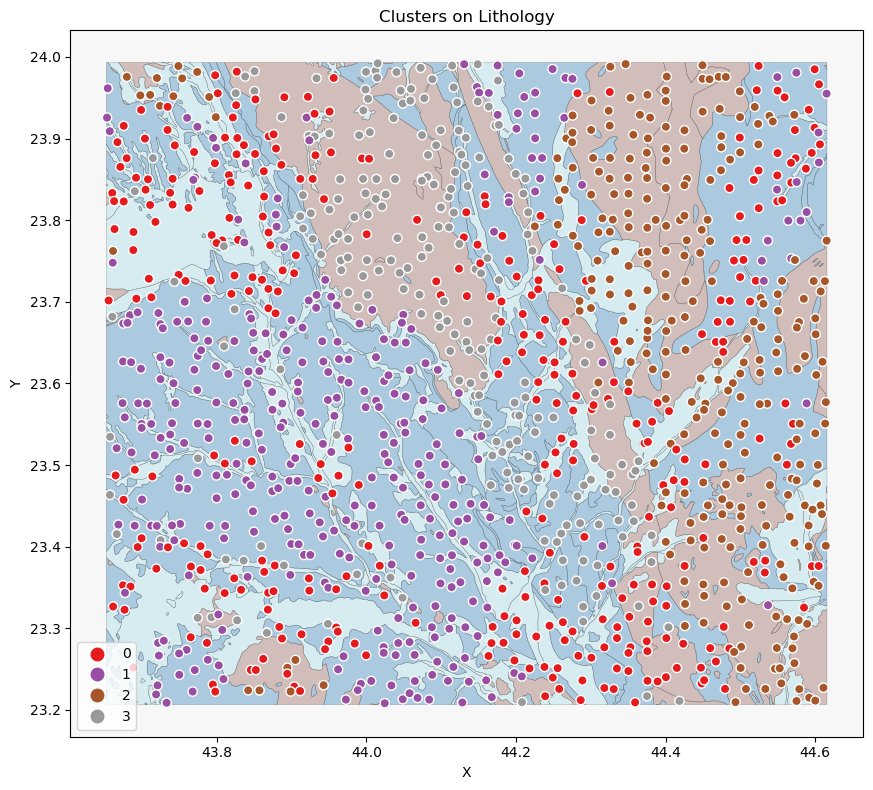

In [17]:
# Plot k-means clusters on lithology map

_ = h.plot_clusters_on_lithology(vector_gdf, geochem_gdf, cluster_labels)
h.show_plot()


**Clusters vs. Lithology:**

Overlaying cluster assignments on the lithology map tests whether geochemical populations correlate with mapped rock units:

- **Cluster 2 (brown)** dominates the eastern portion—appears to align with the pinkish lithology unit
- **Cluster 1 (purple)** is scattered but concentrates in the western half
- **Cluster 0 (red)** appears throughout, possibly representing a background signature
- **Cluster 3 (gray)** shows a broad distribution

**Interpretation:** There's a partial correlation between clusters and lithology, but it's not one-to-one. This is expected—geochemistry reflects both primary rock composition AND secondary processes (weathering, alteration, mineralization). Clusters that cut across lithological boundaries might highlight zones affected by hydrothermal alteration or supergene enrichment.

-----------

### Multivariate Anomaly Detection (Isolation Forest)

**The challenge:** Traditional anomaly detection looks at one element at a time (e.g., "Cu > 50 ppm is anomalous"). But mineralization often involves subtle multi-element signatures that aren't extreme in any single variable.

**Isolation Forest approach:**
- Builds many random decision trees that try to "isolate" each sample
- Anomalous samples are easier to isolate (require fewer tree splits)
- Returns an anomaly score for each sample

This is an **unsupervised** method—it finds unusual samples without needing known deposits for training.

In [19]:
# --- USER PARAMETERS: Anomaly Detection ---
# contamination: Expected proportion of anomalies in the dataset.
#   0.05 = flag top 5% as anomalies (default, moderate)
#   0.01 = flag top 1% as anomalies (conservative, only extreme outliers)
#   0.10 = flag top 10% as anomalies (permissive, catches subtler anomalies)
#
# Lower values → fewer anomalies flagged → higher confidence targets
# Higher values → more anomalies flagged → may include false positives
# Choose based on follow-up capacity: how many targets can you realistically investigate?

contamination = 0.05  # Try: 0.01 (strict), 0.10 (permissive)

In [20]:
# Prepare and fit Isolation Forest model

print('Preparing anomaly detection inputs...')
X_anom, anom_cols = h.prepare_anomaly_inputs(geochem_gdf, feature_cols)
print(f'Anomaly inputs ready: {len(anom_cols)} features')

print('Fitting Isolation Forest...')
anom_labels, anom_scores = h.fit_isolation_forest_model(X_anom, contamination=contamination)
print('Isolation Forest complete')

Preparing anomaly detection inputs...
Anomaly inputs ready: 57 features
Fitting Isolation Forest...
Isolation Forest complete


Anomalies flagged: 63 of 1243 samples (5.1%)


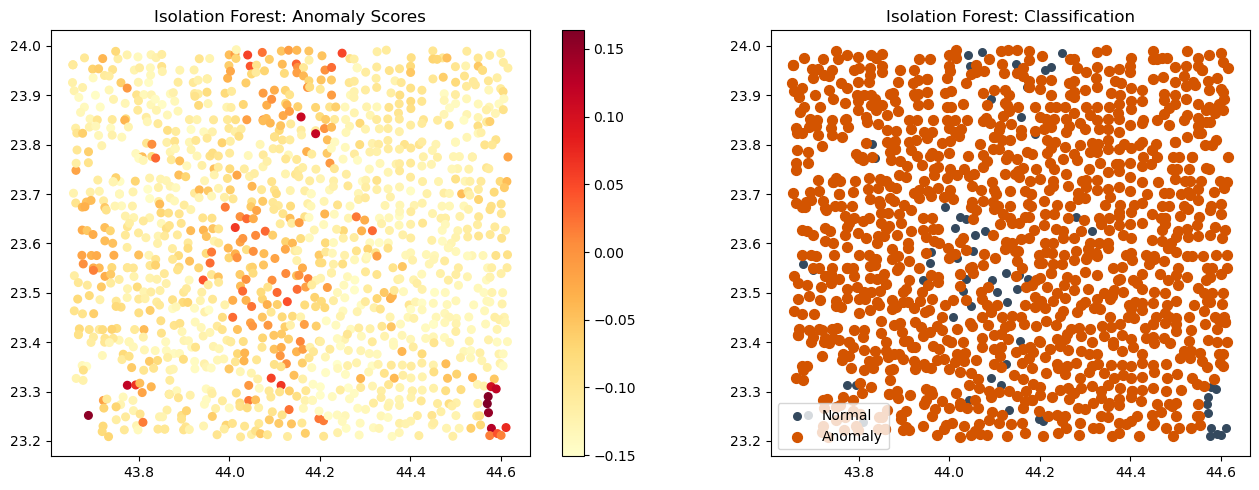

In [22]:
# Spatially plot anomaly detection results

n_anomalies = (anom_labels == -1).sum()
print(f'Anomalies flagged: {n_anomalies} of {len(anom_labels)} samples ({n_anomalies/len(anom_labels):.1%})')

_ = h.plot_anomaly_scores(geochem_gdf, anom_scores, binary_labels=anom_labels, title='Isolation Forest')
h.show_plot()

**Isolation Forest Results:**

**Left (Anomaly Scores):** Continuous scores where higher (darker red) = more anomalous. Note the scattered distribution of high scores—anomalies appear in multiple areas including the southern corners and spots in the upper-center.

**Right (Classification):** Binary labels using a 5% contamination threshold—the top 5% most anomalous samples are flagged. Most samples are "Normal" (orange), with a small number flagged as "Anomaly" (blue).

**Interpretation:** The anomalies don't form a single cluster—they're distributed across the study area. This could indicate:
- Multiple mineralization styles or processes
- Edge effects near boundaries
- Genuine multi-element outliers worth follow-up sampling

Anomaly cutoff is based on the top 5% most extreme scores.
Lowering contamination flags fewer anomalies; raising it flags more.


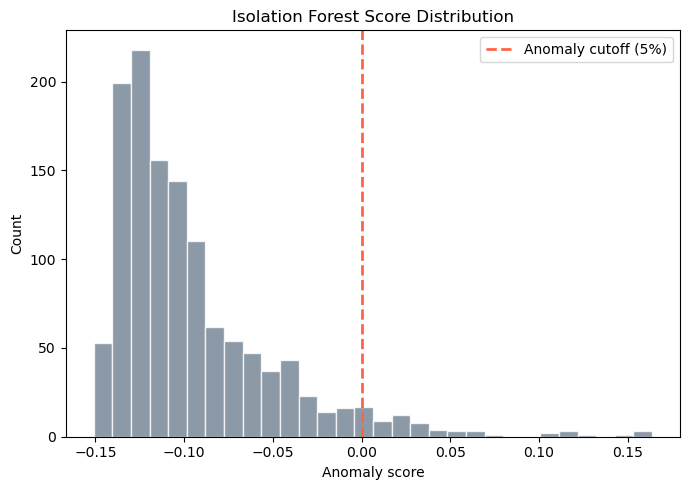

In [23]:
# Plot anomaly score distribution

print(f'Anomaly cutoff is based on the top {contamination:.0%} most extreme scores.')
print('Lowering contamination flags fewer anomalies; raising it flags more.')
_ = h.plot_anomaly_score_distribution(anom_scores, contamination=contamination)
h.show_plot()

**Score Distribution:**

This histogram shows the distribution of anomaly scores:
- Most samples have negative scores (normal)
- The red dashed line at 0 marks the 5% cutoff
- A long tail extends to positive values (the anomalies)

**Tuning the threshold:** The 5% contamination is a starting point. In practice:
- Lower contamination (1-2%) = fewer, more extreme anomalies
- Higher contamination (10%) = more permissive, catches subtler anomalies

The "right" threshold depends on your exploration strategy—how many targets can you realistically follow up?

-----------

### Spectral Halo Classification

**What this is:** Using satellite imagery (Sentinel-2) to map alteration minerals based on their spectral signatures.

**The indices we use:**
- **Clay/AlOH:** Highlights clay minerals (kaolinite, illite, smectite)
- **Ferrous Iron:** Detects Fe²⁺ in minerals like chlorite
- **Iron Oxide:** Maps Fe³⁺ (hematite, goethite)—common in gossans
- **Silica:** Proxy for silicification

These indices are combined to classify alteration types that are diagnostic of different mineralization environments.

Loading spectral indices...
Loaded 6 spectral index rasters


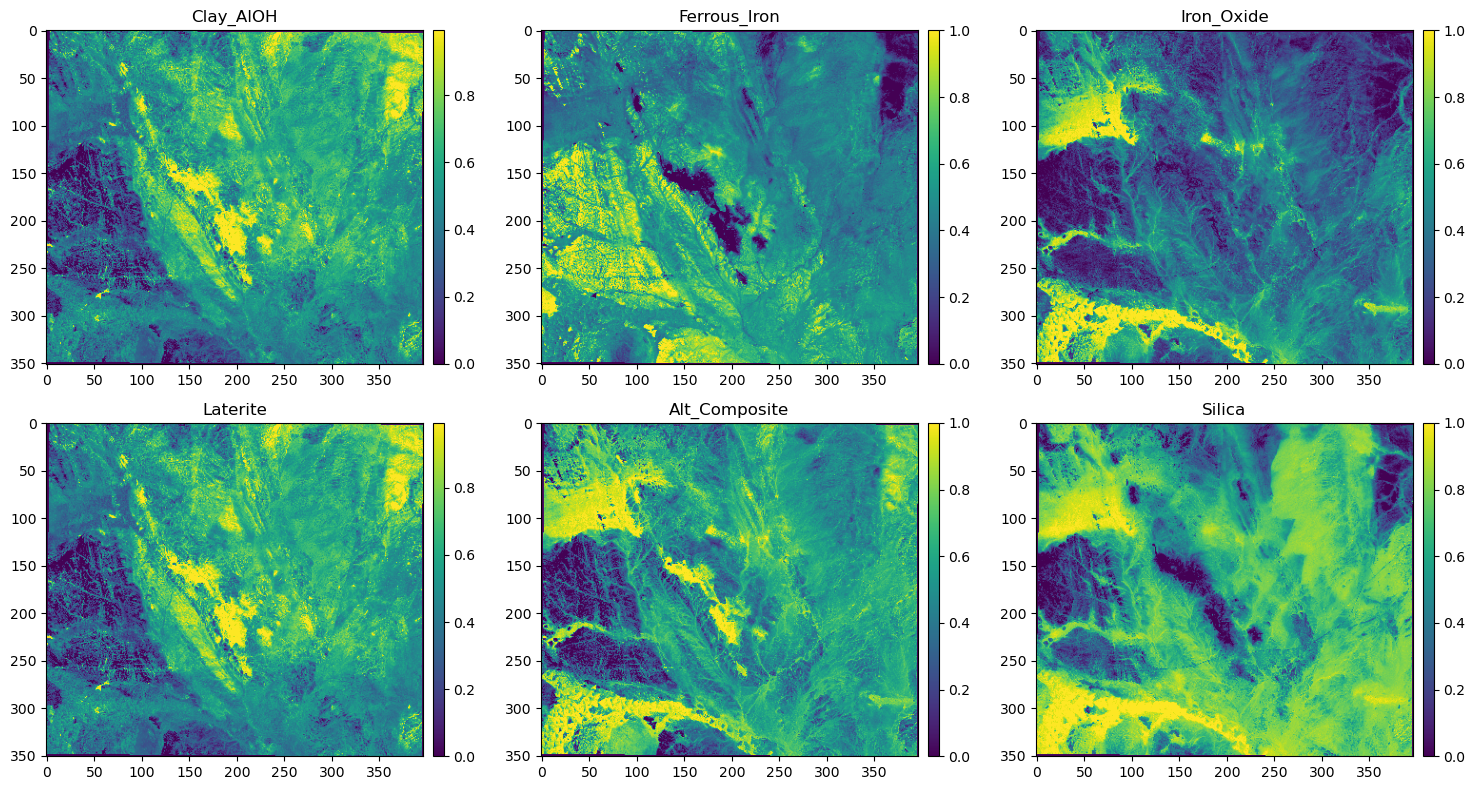

In [24]:
# Load and plot spectral indices

print('Loading spectral indices...')
spectral_indices, spectral_extent = h.load_spectral_indices_dir()
print(f'Loaded {len(spectral_indices)} spectral index rasters')

spectral_indices = h.map_spectral_indices(spectral_indices)
valid_mask = h.spectral_valid_mask(spectral_indices)
_ = h.plot_spectral_indices_grid(spectral_indices)
h.show_plot()

**Spectral Index Maps:**

Each panel shows a different mineral index (0-1 scale, yellow = high):

- **Clay_AlOH:** Strong responses in the NW and along a SW-NE trend. These areas likely contain exposed clay-rich alteration.
- **Ferrous_Iron:** Concentrated in the central-south region with distinct patches.
- **Iron_Oxide:** Similar to Gossan but with different intensity patterns.
- **Laterite:** Strong in the SW and south—represents deeply weathered terrain.
- **Alt_Composite:** Combined alteration signal highlighting overlap zones.
- **Silica:** Patchy distribution with high values in the NW.

**Key observation:** Different indices highlight different areas, but there are zones of overlap (particularly in the south and NW) where multiple alteration types coincide—these are often the most prospective targets.

In [25]:
# --- USER PARAMETERS: Halo Detection ---
# presence_quantile: Threshold for defining "high" index values (used to create binary presence masks).
#   0.9  = top 10% of values are considered "present" (conservative)
#   0.75 = top 25% of values are considered "present" (more inclusive)

presence_quantile = 0.9       # Try: 0.75, 0.85, 0.95


# sigma_px: Gaussian smoothing radius in pixels for KDE surfaces.
#   Higher values = smoother, broader halos (regional patterns)
#   Lower values  = sharper, more localized halos (local anomalies)

sigma_px = 50                 # Try: 25 (sharper), 75 (smoother)


# clip_q: Quantile range for normalizing KDE surfaces. Format: (lower, upper).
#   (0.01, 0.99) = removes extreme 1% on each end for better visualization

clip_q = (0.01, 0.99)         # Try: (0.05, 0.95) for more aggressive clipping

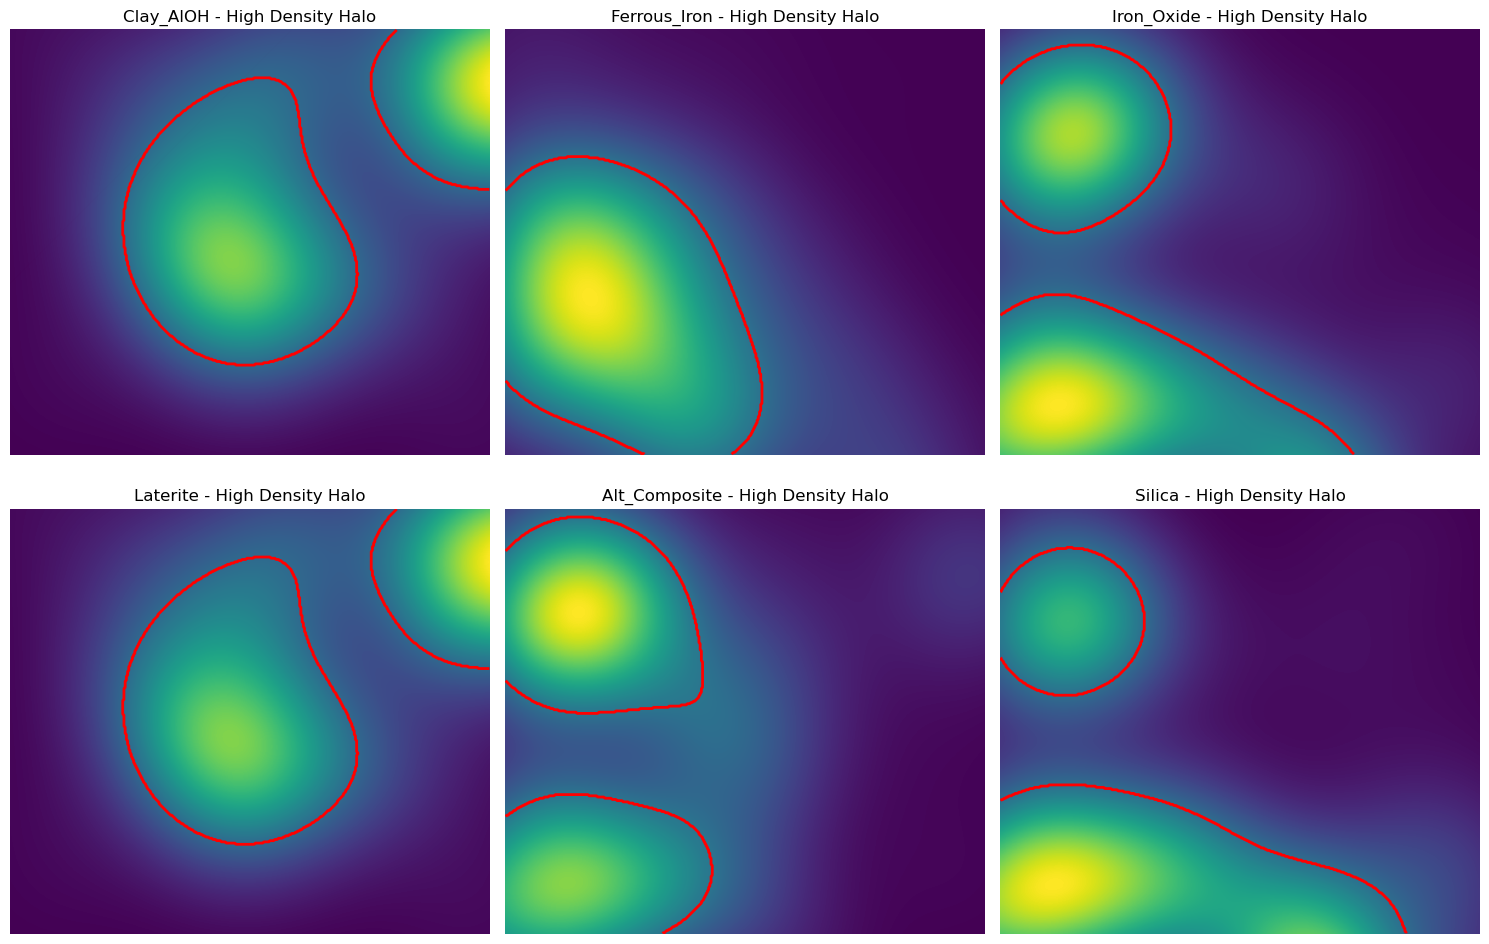

In [26]:
# Run halo detection workflow

kde_surfaces, halo_masks = h.run_halo_detection_workflow(
    spectral_indices,
    presence_quantile=presence_quantile,
    sigma_px=sigma_px,
    clip_q=clip_q,
    valid_mask=valid_mask,
)
_ = h.plot_halo_detection_results(kde_surfaces, halo_masks)
h.show_plot()

**High-Density Halo Detection:**

These smoothed maps (KDE = kernel density estimation) show where each alteration type is concentrated. The red contours delineate high-density "halos":

- **Clay_AlOH:** Two main centers—one in the NW, one in the SW
- **Ferrous_Iron:** Single strong center in the NW
- **Iron_Oxide:** Matches the Gossan pattern closely
- **Laterite:** Large halo in the center-west
- **Alt_Composite:** Integrated view showing the NW as a key convergence zone
- **Silica:** NW focus, overlapping with clay and ferrous iron

**Exploration significance:** The NW quadrant shows overlapping halos for multiple alteration types—this spatial coincidence suggests a potential hydrothermal center worth investigating on the ground.

In [27]:
# --- USER PARAMETERS: Alteration Classification ---
# confidence_percentile: Minimum confidence threshold for assigning an alteration class.
#   Pixels below this percentile of the max score are labeled "Background".
#   20 = moderately permissive (more pixels get classified)
#   40 = stricter (only higher-confidence pixels get classified)
#   10 = very permissive (most pixels get a class assignment)
#
# Lower values → more area classified → potentially more false positives
# Higher values → less area classified → potentially missing subtle alteration

confidence_percentile = 20  # Try: 10 (permissive), 30 (moderate), 50 (strict)

Alteration type classes:
0: Background
1: Advanced Argillic (6049 pixels, 4.4%)
2: Phyllic (14897 pixels, 10.7%)
3: Argillic (11380 pixels, 8.2%)
4: Propylitic (28646 pixels, 20.6%)
5: Gossan (15435 pixels, 11.1%)
6: Laterite (34790 pixels, 25.0%)


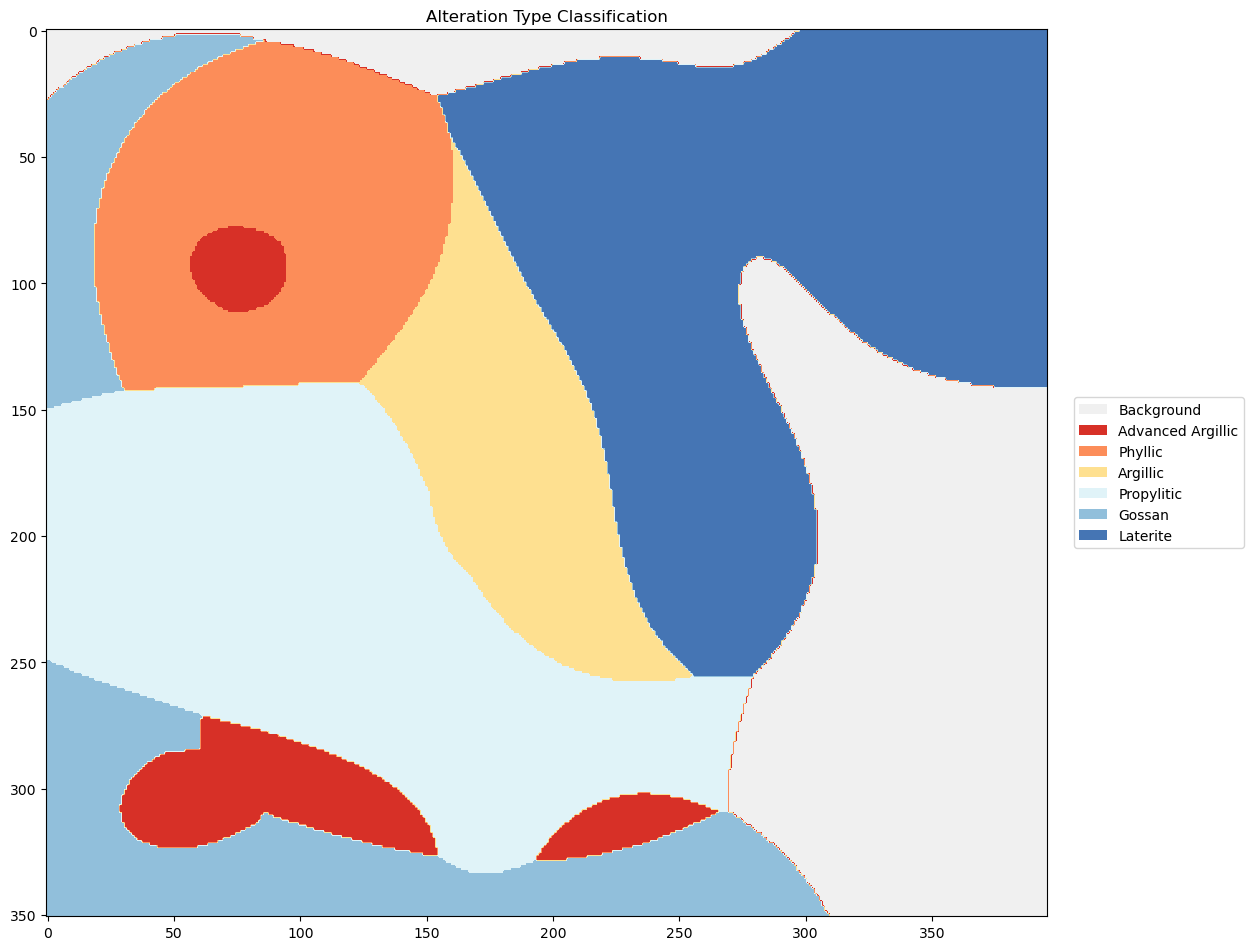

In [28]:
# Classify alteration types

alteration_weights = h.default_alteration_weights()
class_map, class_names, alteration_scores = h.classify_alteration_types(
    kde_surfaces,
    alteration_weights,
    valid_mask=valid_mask,
    confidence_percentile=confidence_percentile,
)
h.summarize_alteration_classes(class_map, class_names)
_ = h.plot_alteration_map(class_map, class_names=class_names, figsize=(12, 10))
h.show_plot()

**Alteration Type Classification:**

This map shows the dominant alteration type at each pixel based on weighted combinations of spectral indices:

| Class | Coverage | Interpretation |
|-------|----------|----------------|
| **Advanced Argillic** (red) | 3.5% | Intense acid alteration—potential proximity to fluid source |
| **Phyllic** (orange) | 13.2% | Sericite-rich; common in porphyry halos |
| **Argillic** (yellow) | 8.2% | Intermediate clay alteration |
| **Propylitic** (cyan) | 20.3% | Distal, lower-temperature alteration |
| **Gossan** (light blue) | 10.2% | Oxidized sulfide zones |
| **Laterite** (dark blue) | 24.7% | Deep weathering profile |
| **Background** (gray) | ~20% | Unclassified/weak signal |

**Pattern interpretation:** Notice the classic alteration zonation in the NW—Advanced Argillic core (red) surrounded by Phyllic (orange), then Argillic (yellow), then Propylitic (cyan). This concentric pattern is textbook epithermal or porphyry alteration zoning.

The southern zone shows Gossan and Laterite dominance, suggesting a weathered sulfide occurrence.

-----------

### Supervised ML Prospectivity Mapping

**The difference from previous methods:** Until now, we've used unsupervised methods that find patterns without knowing where mineralization actually occurs. Supervised ML uses **known deposits** (training labels) to learn what combination of features predicts prospectivity.

**The workflow:**
1. Create a "data cube" stacking all feature layers (geochem, geophysics, spectral indices, lithology)
2. Extract feature values at known deposit locations (positive labels) and background locations (negative labels)
3. Train a model (e.g., Random Forest, Gradient Boosting) to distinguish them
4. Apply the trained model to predict prospectivity across the entire area

**Important:** Model performance depends heavily on training data quality and spatial validation approach.

--------

 **NOTE:** *For the sake of this exercise and to avoid heavy compute usage, we have pre-generated these ML results below. The code below walks through visualizing each step of the process, including the input "data cube," the model's probability outputs, and the various ways we can interpret the model's outputs.*

In [ ]:
# Visualize feature-engineered "data cube"

h.display_data_cube_viewer('data/ML')

Loaded data cube from: /Users/thowe/Documents/Work/SGS_training/data/ML/DCG.nc


Loaded workflow artifacts from: /Users/thowe/Documents/Work/SGS_training/data/ML


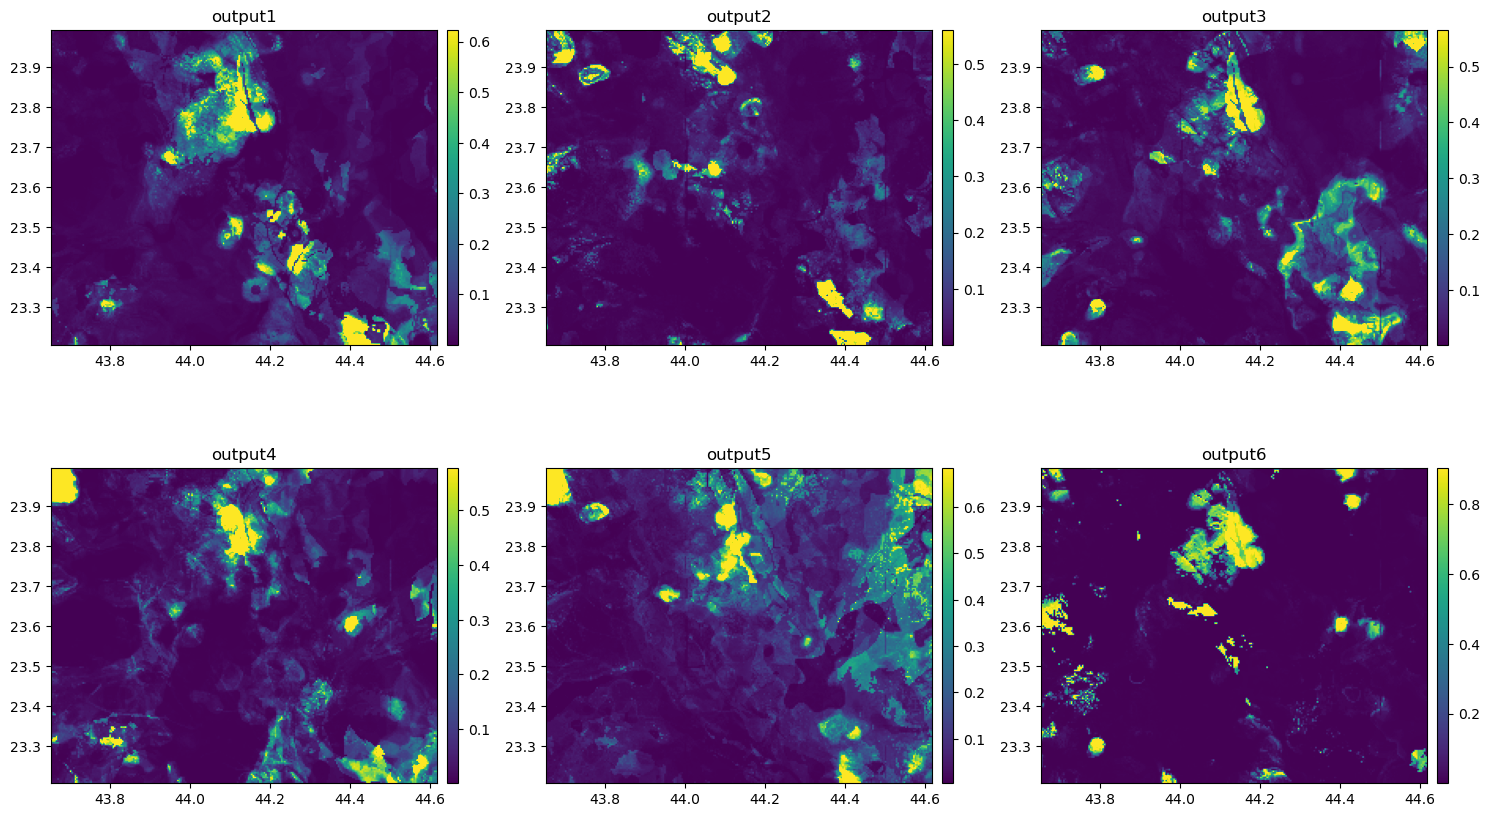

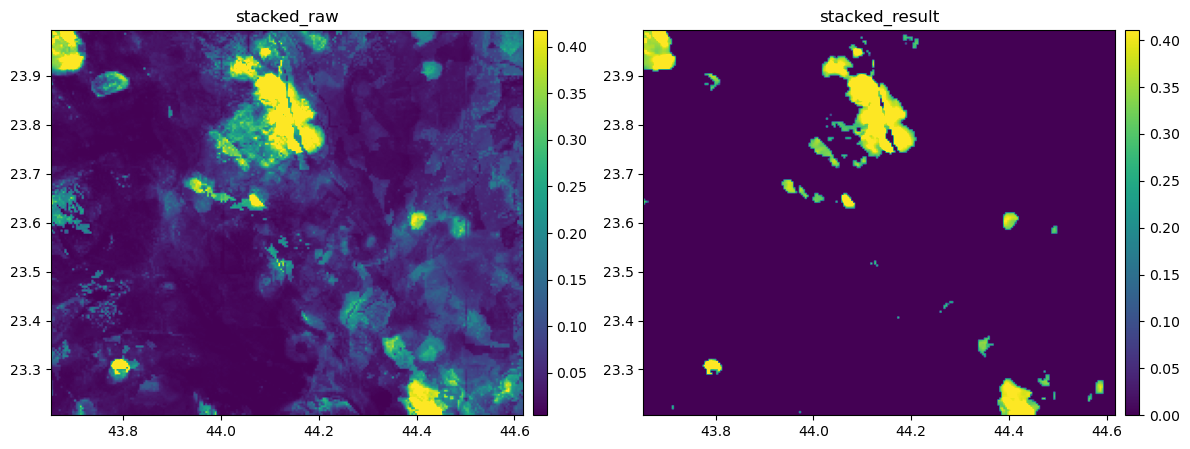

In [ ]:
# Visualize model outputs

h.display_model_outputs('data/ML')

**Model Outputs:**

The top row shows raw probability outputs from different model configurations (output1-6). Each represents prospectivity predictions using different train/test split scenarios. Utilizing multiple individual model runs with different scales of spatial test/train splits allows for us to better mitigate the effects of spatial autocorrelation.

**Stacked Results (bottom):**
- **stacked_raw:** Average of all model outputs—shows consistent high-probability zones
- **stacked_result:** Smoothed and thresholded version keeping only (relatively) high-confidence predictions

**Interpretation:** The models consistently highlight:
- A major prospective zone in the upper-center (around 44.0-44.2 longitude, 23.7-23.9 latitude)
- Scattered smaller targets in the south and east
- The central-east area shows moderate prospectivity

The agreement between models increases confidence—areas highlighted by multiple models are more robust targets.

Loaded interpretability artifacts from: /Users/thowe/Documents/Work/SGS_training/data/ML


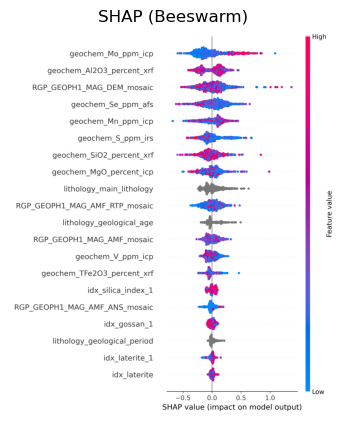

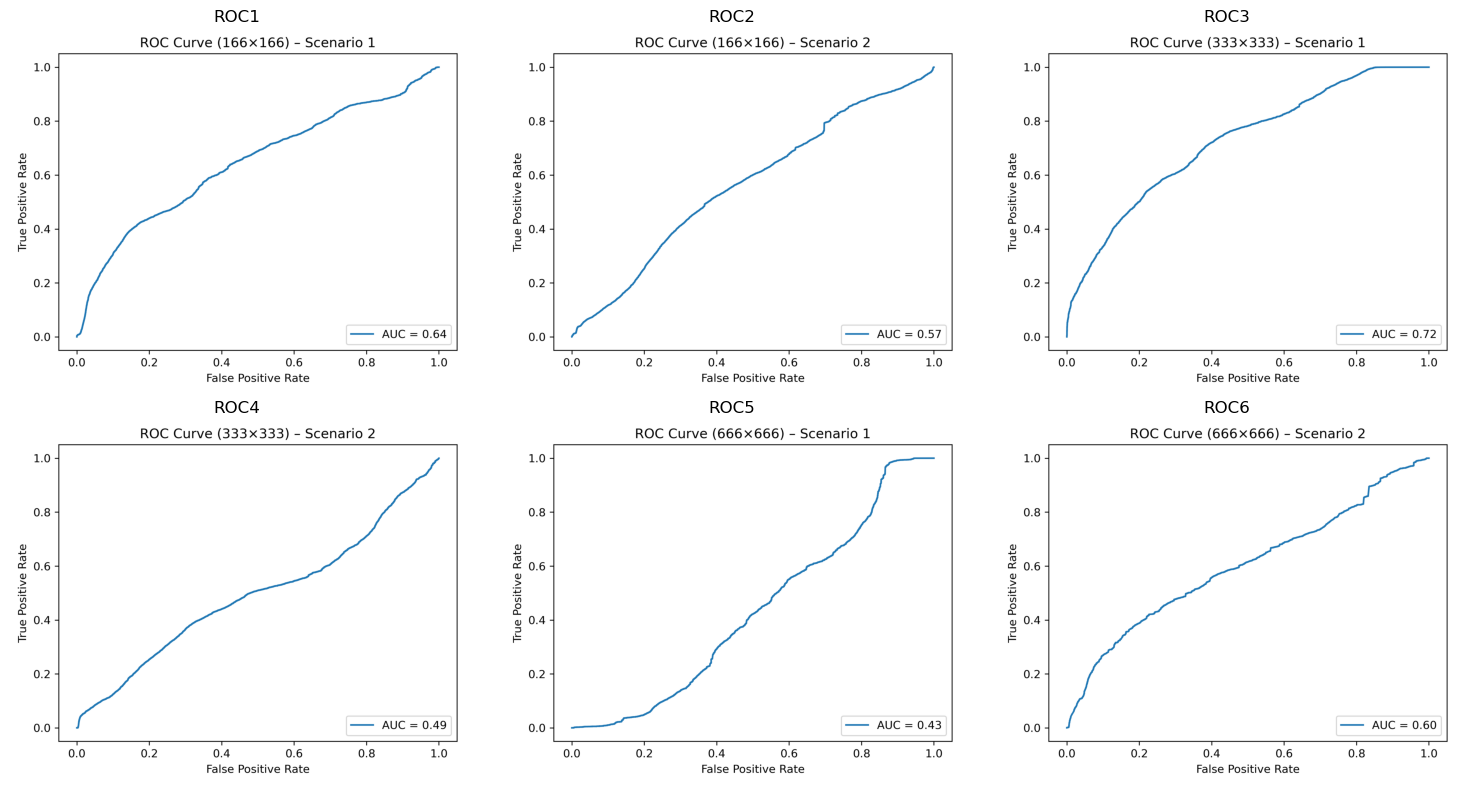

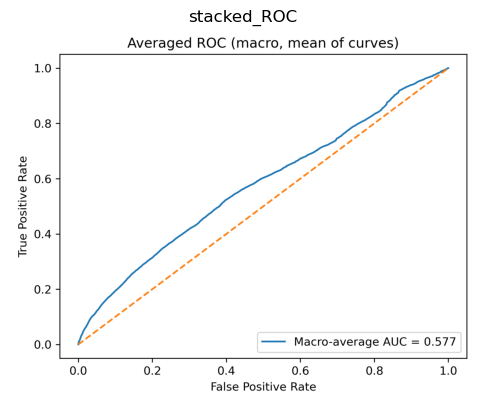

In [31]:
# Visualize model interpretability outputs

h.display_interpretability_outputs('data/ML')

**Model Interpretability (SHAP):**

SHAP (SHapley Additive exPlanations) tells us which features drive the model's predictions:

- Each row is a feature, ordered by importance (most important at top)
- Each dot is a sample; color shows feature value (pink = high, blue = low)
- Position on x-axis shows impact on prediction (right = increases prospectivity)

**Key insights:**
- **Mo_ppm_icp** is most important—high Mo strongly increases predicted prospectivity
- **Al₂O₃** matters, with lower values associated with higher prospectivity
- **Geophysics (MAG_DEM_mosaic)** contributes significantly
- **Lithology variables** appear in the top 20—geology matters!

**ROC Curves:**

The ROC (Receiver Operating Characteristic) curves show model performance, with a numeric score (Area Under the Curve):
- **AUC = 0.5** means random guessing
- **AUC = 1.0** means perfect prediction

Individual model AUCs range from 0.43 to 0.72 across different scenarios and scales. The macro-average AUC of 0.577 indicates modest predictive power—typical for geological prospectivity where deposit signatures are complex and training data is limited.

**Takeaway:** The model has learned real signal (AUC > 0.5), but prospectivity mapping remains challenging. Use model outputs to prioritize targets, not as definitive answers.

---

## Summary and Next Steps

In this notebook, we've walked through a toolkit of analytical methods for mineral exploration:

| Method | What it does | When to use it |
|--------|--------------|----------------|
| **IDW/Kriging** | Interpolates point data to surfaces | Visualizing geochem patterns, resource estimation |
| **PCA** | Reduces dimensions, finds element associations | Exploratory analysis, identifying signatures |
| **K-means** | Groups samples into populations | Defining geochemical domains |
| **Isolation Forest** | Flags multivariate anomalies | Target generation without training data |
| **Spectral Classification** | Maps alteration from imagery | Regional targeting, alteration mapping |
| **Supervised ML** | Predicts prospectivity from known deposits | Ranking targets when training data exists |

**Key takeaways:**
1. No single method tells the whole story—integrate multiple approaches
2. Unsupervised methods are valuable when you lack training data
3. Supervised methods require careful spatial validation
4. Always ground-truth model outputs with geological reasoning

**From here:** The targets identified by these analyses should be validated in the field. Compare model predictions against known geology, collect additional samples in highlighted areas, and iterate on the analysis as new data becomes available.